# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
n = 10

k1 = 8
p1 = k1 / n

k2 = 2
p2 = k2 / n

h = np.round(- (p1 * np.log(p1) + p2 * np.log(p2)), 2)
print(f'{h:0.2f}')

0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def H_Gini(selection, task="classification"):
    selection = np.array(selection)
    if len(selection) == 0:
        return 0.0
    
    if task == "classification":
        p = np.mean(selection == 1)  # =доля класса 1
        return p * (1 - p)
    else:
        return np.var(selection, ddof=0)


def Q_old(R_m: pd.DataFrame, j, t):
    R_m = R_m[j].apply(lambda x: 1 if x >= t else 0)
    R_l = R_m[R_m[j] == 0]
    R_r = R_m[R_m[j] == 1]
    return round(H_Gini(R_m, j) - len(R_l) / len(R_m) * H_Gini(R_l, j) - len(R_r) / len(R_m) * H_Gini(R_r, j), 2)

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

np.float64(40.6)

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def Q(feature_vector: Union[np.ndarray, pd.Series], target_vector: Union[np.ndarray, pd.Series], thresholds: Union[float, np.ndarray], task: str = "classification", feature_type: str = "real") -> float:
    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)
    thresholds = np.array(thresholds)

    mask = ~np.isnan(feature_vector) & ~np.isnan(target_vector)
    feature_vector = feature_vector[mask]
    target_vector = target_vector[mask]
    
    if len(feature_vector) == 0:
        return np.array(np.inf if task == "regression" else -np.inf)

    left_masks = feature_vector[:, None] <= thresholds[None, :] if feature_type == "real" else feature_vector[:, None] == thresholds[None, :]
    right_masks = ~left_masks
    n_total = len(feature_vector)
    n_left = np.sum(left_masks, axis=0)
    n_right = n_total - n_left
    valid_mask = (n_left > 0) & (n_right > 0)
    if not np.any(valid_mask):
        return np.array(np.inf if task == "regression" else -np.inf)
    
    h_total = H_Gini(target_vector, task)
    
    if task == "classification":
        # Для классификации: считаем Джини через np.bincount
        def h_gini_s(y, masks):
            counts = np.array([np.bincount(y[m], minlength=np.max(y) + 1) for m in masks.T])
            counts = counts / np.sum(counts, axis=1, keepdims=True)
            return 1 - np.sum(counts ** 2, axis=1)
        
        h_left = np.zeros_like(n_left, dtype=float)
        h_right = np.zeros_like(n_left, dtype=float)
        h_left[valid_mask] = h_gini_s(target_vector, left_masks[:, valid_mask])
        h_right[valid_mask] = h_gini_s(target_vector, right_masks[:, valid_mask])
    else:
        left_means = np.array([np.mean(target_vector[m]) if np.any(m) else 0 for m in left_masks.T])
        right_means = np.array([np.mean(target_vector[m]) if np.any(m) else 0 for m in right_masks.T])
        
        h_left = np.array([
            np.mean((target_vector[m] - left_means[i]) ** 2) if np.any(m) else 0
            for i, m in enumerate(left_masks.T)
        ])
        h_right = np.array([
            np.mean((target_vector[m] - right_means[i]) ** 2) if np.any(m) else 0
            for i, m in enumerate(right_masks.T)
        ])
    
    q_values = np.full_like(n_left, np.inf if task == "regression" else -np.inf, dtype=float)
    q_values[valid_mask] = h_total - (n_left[valid_mask] / n_total * h_left[valid_mask] + n_right[valid_mask] / n_total * h_right[valid_mask])
    
    return q_values
    
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов, len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    
    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)
    
    mask = ~np.isnan(feature_vector) & ~np.isnan(target_vector)
    feature_vector = feature_vector[mask]
    target_vector = target_vector[mask]
    
    if len(feature_vector) == 0:
        return np.array([]), np.array([]), np.nan, np.nan
    
    if feature_type == "real":
        unique_features = np.unique(feature_vector)
        if len(unique_features) <= 1:
            return np.array([]), np.array([]), np.nan, np.nan
        thresholds = (unique_features[:-1] + unique_features[1:]) / 2
    else:
        thresholds = np.unique(feature_vector)
    
    ginis = Q(feature_vector, target_vector, thresholds, task, feature_type)
        
    valid_mask = np.isfinite(ginis)
    thresholds = thresholds[valid_mask]
    ginis = ginis[valid_mask]
    
    if len(thresholds) == 0:
        return np.array([]), np.array([]), np.nan, np.nan
    
    index_best = np.argmin(ginis) if task == "classification" else np.argmax(ginis)     
    threshold_best = thresholds[index_best]
    gini_best = ginis[index_best]
    
    return thresholds, ginis, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,))

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

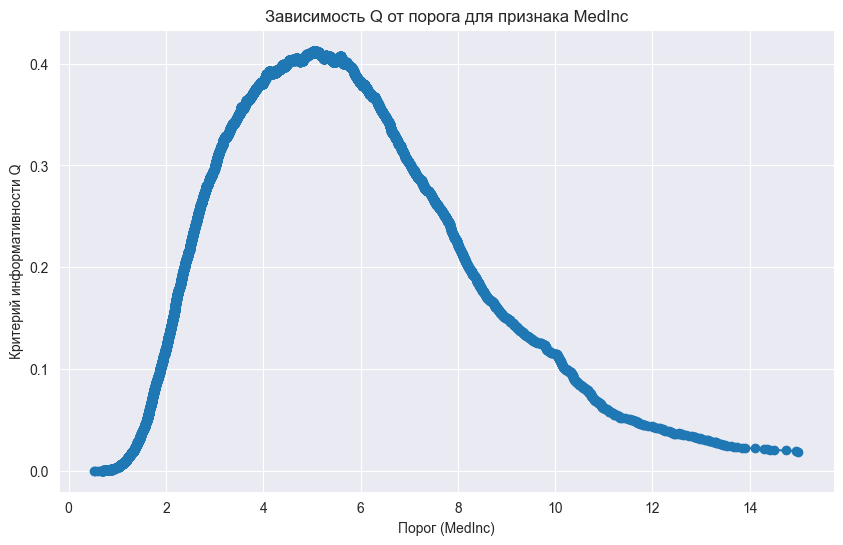

Лучший порог: 5.03515
Максимальное Q: 0.41275138620167695


In [10]:
feature_vector = X["MedInc"]
target_vector = y

thresholds, ginis, threshold_best, gini_best = find_best_split(
    feature_vector, 
    target_vector, 
    task="regression", 
    feature_type="real"
)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, ginis, marker='o', linestyle='-', color='#1f77b4')
plt.xlabel('Порог (MedInc)')
plt.ylabel('Критерий информативности Q')
plt.title('Зависимость Q от порога для признака MedInc')
plt.show()

# выводим лучший порог и увеличение Q
print(f"Лучший порог: {threshold_best}")
print(f"Максимальное Q: {gini_best}")

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [11]:
print(f"Лучший предикат (свойство с порогом): MedInc <= {threshold_best}")

Лучший предикат (свойство с порогом): MedInc <= 5.03515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [12]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        self._current_depth = 0

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict,
        depth: int = 0
    ) -> None:
        
        # критерий останова по вырожденному случаю
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
        
        # критерий останова по превышению максимальной глубины
        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # критерий останова по нулевому количеству объектов для разделения
        if self._min_samples_split is not None and len(sub_X) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # критерий останова по малому количеству объектов в листе
        if self._min_samples_leaf is not None and len(sub_X) < 2 * self._min_samples_leaf:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            feature_vector = sub_X[:, feature]
            
            # пропускаем признаки с пропусками или без вариации
            if np.all(np.isnan(feature_vector)) or len(np.unique(feature_vector[~np.isnan(feature_vector)])) <= 1:
                continue

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or (self.task == "classification" and gini > gini_best) or (self.task == "regression" and gini < gini_best):
                feature_best = feature
                gini_best = gini
                threshold_best = threshold

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError
        
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # учитываем важность признака
        if feature_best not in self._feature_importances:
            self._feature_importances[feature_best] = 0
        self._feature_importances[feature_best] += gini_best if self.task == "classification" else -gini_best

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        # обработка пропусков: направляем в большее поддерево
        n_left = np.sum(split)
        n_right = len(split) - n_left
        node["n_left"] = n_left
        node["n_right"] = n_right
        split[np.isnan(feature_vector)] = n_right >= n_left
        
        # проверяем min_samples_leaf для подвыборок
        if self._min_samples_leaf is not None and (n_left < self._min_samples_leaf or n_right < self._min_samples_leaf):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]

        feature_idx = node["feature_split"]
        feature_value = x[feature_idx]

        # обработка пропусков
        if np.isnan(feature_value):
            if node["n_left"] >= node["n_right"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

        if self._feature_types[feature_idx] == "real":
            if feature_value <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if feature_value == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [13]:
df = pd.read_csv("students.csv")
features = df.columns[1:-1]
x = df[features]
y = df["UNS"]
x

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58
254,0.78,0.61,0.71,0.19,0.60
255,0.54,0.82,0.71,0.29,0.77
256,0.50,0.75,0.81,0.61,0.26


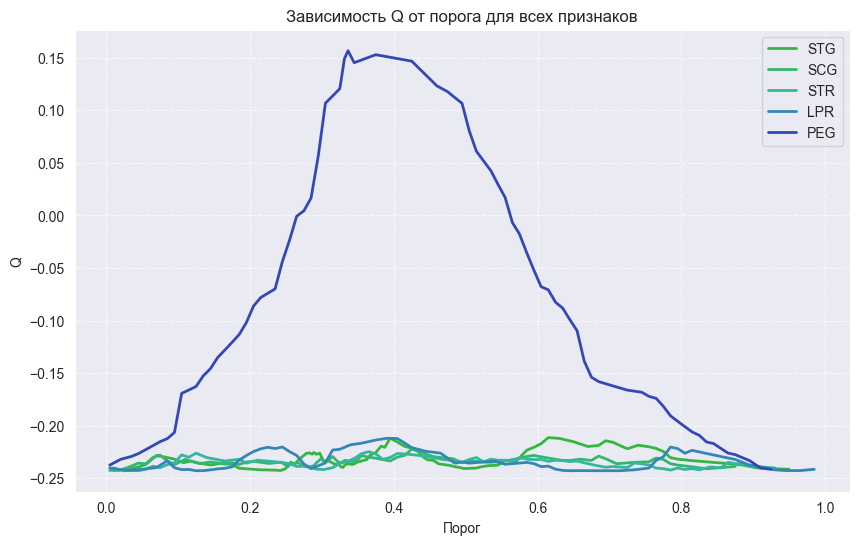

In [14]:
outputs = [find_best_split(x[i], y, task="classification", feature_type="real") for i in features]

plt.figure(figsize=(10, 6))
colors = ["#33b740", "#33b770", "#33b79f", "#3387b7", "#3348b7", "#4d33b7"]
for i in range(len(features)):
    plt.plot(outputs[i][0], outputs[i][1], label=features[i], color=colors[i], linewidth=2)
plt.xlabel('Порог')
plt.ylabel('Q')
plt.title('Зависимость Q от порога для всех признаков')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

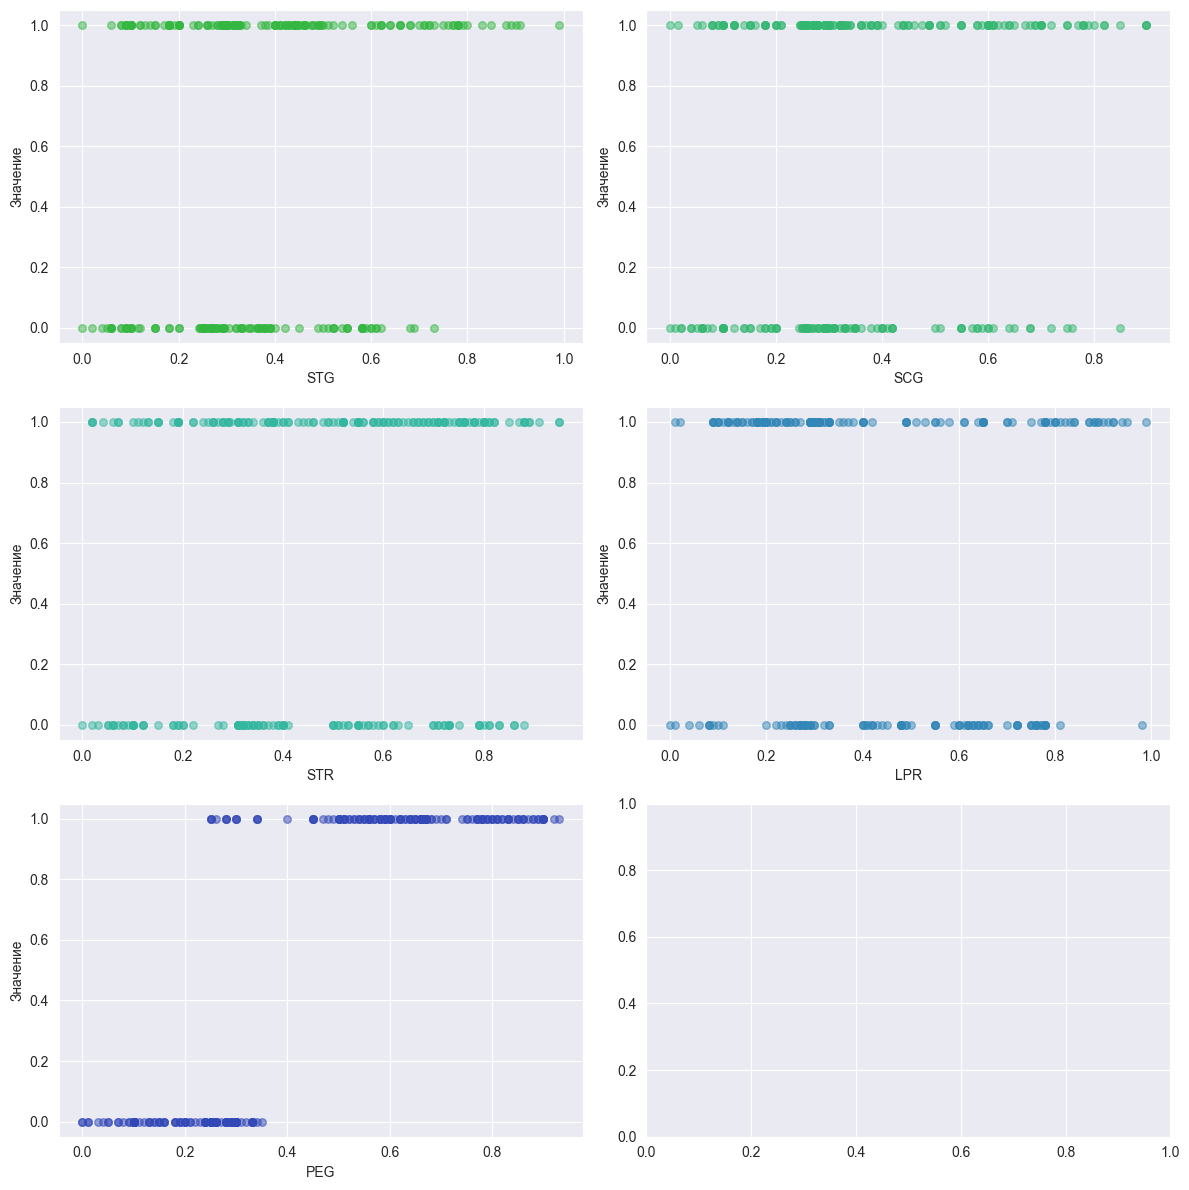

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()
for i, feature in enumerate(features):
    axes[i].scatter(x[feature], y, alpha=0.5, color=colors[i], s=30)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Значение')
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

- Нужно производить деление выборки на два поддерева однозначно по свойству PEG, потому что именно это свойство имеет наибольший и выраженный критерий информативности по сравнению с другими свойствами.
- Да, это согласуется с визуальной оценкой диаграмм рассеяния, потому что единственная диаграмма, на которой можно практически ровно разделить вертикальной прямой выборку на положительные и отрицательные классы - PEG.
- Кривая для "хороших" признаков, по которым выборка делится почти идеальна, характеристики следующие: выраженный пик в точке оптимального порога и достаточно высокое значение Q (около 0.5 для сбалансированной выборки).
- Кривые для признаков, по которым деление практически невозможно, всегда держатся на одном (невысоком) уровне Q, нет одного выраженного пика, заметны сильные колебания

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("agaricus-lepiota.data", header=None)

label_encoders = {}
X = df.iloc[:, 1:].copy()
y = df.iloc[:, 0].copy()
for col in X.columns:
    LE = LabelEncoder()
    X[col] = LE.fit_transform(X[col].astype(str))
    label_encoders[col] = LE
le_y = LabelEncoder()
y = le_y.fit_transform(y.astype(str))
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.5, random_state=52
)

tree = DecisionTree(
    feature_types=["categorical"] * X_train.shape[1],
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    task="classification"
)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовой выборке: {accuracy}")

Accuracy на тестовой выборке: 1.0


Воу.... Странно, но все пишут, что у них тоже 1.0, поэтому, в целом, оставлю так. Но в других случаях я бы задумался о даталике

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [17]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [18]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
print(data.head())

Dataset shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


Посмотрим на распределение целевой переменной

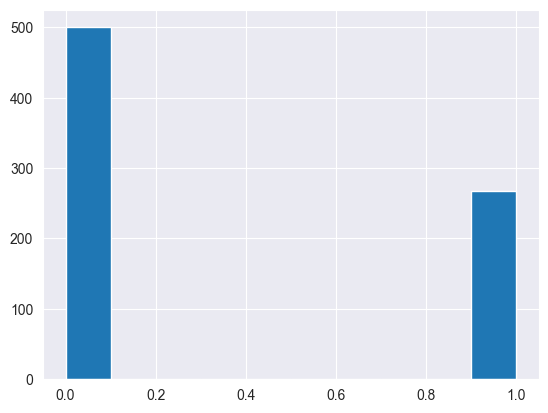

In [19]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [20]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=52)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=52)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [21]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

max_depth_to_try_tree = [3, 5, 7, 10, None]
min_samples_leaf_to_try_tree = [1, 2, 5, 10]

best_f1_tree = 0
best_params_tree = {'max_depth': None, 'min_samples_leaf': None}
f1_scores_tree = []

for max_depth_cur in max_depth_to_try_tree:
    for min_samples_leaf_cur in min_samples_leaf_to_try_tree:
        tree = DecisionTreeClassifier(
            max_depth=max_depth_cur,
            min_samples_leaf=min_samples_leaf_cur,
            random_state=52
        )
        tree.fit(X_train, y_train)        
        y_pred_val = tree.predict(X_val)
        
        f1 = f1_score(y_val, y_pred_val)
        f1_scores_tree.append((max_depth_cur, min_samples_leaf_cur, f1))
        
        if f1 > best_f1_tree:
            best_f1_tree = f1
            best_params_tree['max_depth'] = max_depth_cur
            best_params_tree['min_samples_leaf'] = min_samples_leaf_cur
        
        print(f"max_depth={max_depth_cur}, min_samples_leaf={min_samples_leaf_cur}, F1-score={f1}")

print(f"\nBest: max_depth={best_params_tree['max_depth']}, min_samples_leaf={best_params_tree['min_samples_leaf']}")
print(f"Best F1 на валидационной выборке: {best_f1_tree}")

max_depth=3, min_samples_leaf=1, F1-score=0.5319148936170213
max_depth=3, min_samples_leaf=2, F1-score=0.5319148936170213
max_depth=3, min_samples_leaf=5, F1-score=0.4946236559139785
max_depth=3, min_samples_leaf=10, F1-score=0.5263157894736842
max_depth=5, min_samples_leaf=1, F1-score=0.7194244604316546
max_depth=5, min_samples_leaf=2, F1-score=0.7338129496402878
max_depth=5, min_samples_leaf=5, F1-score=0.7338129496402878
max_depth=5, min_samples_leaf=10, F1-score=0.6833333333333333
max_depth=7, min_samples_leaf=1, F1-score=0.6666666666666666
max_depth=7, min_samples_leaf=2, F1-score=0.6140350877192983
max_depth=7, min_samples_leaf=5, F1-score=0.6911764705882353
max_depth=7, min_samples_leaf=10, F1-score=0.6363636363636364
max_depth=10, min_samples_leaf=1, F1-score=0.6
max_depth=10, min_samples_leaf=2, F1-score=0.5853658536585366
max_depth=10, min_samples_leaf=5, F1-score=0.6451612903225806
max_depth=10, min_samples_leaf=10, F1-score=0.6833333333333333
max_depth=None, min_samples_lea

In [22]:
tree_best = DecisionTreeClassifier(
    max_depth=best_params_tree['max_depth'],
    min_samples_leaf=best_params_tree['min_samples_leaf'],
    random_state=52
)
tree_best.fit(X_train_full, y_train_full)

y_pred_test_tree = tree_best.predict(X_test)
y_pred_proba_test_tree = tree_best.predict_proba(X_test)[:, 1]

accuracy_tree = accuracy_score(y_test, y_pred_test_tree)
precision_tree = precision_score(y_test, y_pred_test_tree)
recall_tree = recall_score(y_test, y_pred_test_tree)
roc_auc_tree = roc_auc_score(y_test, y_pred_proba_test_tree)

print("\nМетрики на тестовой выборке:")
print(f"Accuracy: {accuracy_tree}")
print(f"Precision: {precision_tree}")
print(f"Recall: {recall_tree}")
print(f"ROC-AUC: {roc_auc_tree}")


Метрики на тестовой выборке:
Accuracy: 0.7662337662337663
Precision: 0.6896551724137931
Recall: 0.5263157894736842
ROC-AUC: 0.7845076400679117


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [23]:
base_tree = DecisionTreeClassifier(
    max_depth=best_params_tree['max_depth'],
    min_samples_leaf=best_params_tree['min_samples_leaf'],
    random_state=52
)
bagging_tree = BaggingClassifier(
    estimator=base_tree,
    n_estimators=50,
    random_state=52
)
bagging_tree.fit(X_train_full, y_train_full)

y_pred_test_bagging = bagging_tree.predict(X_test)
y_pred_proba_test_bagging = bagging_tree.predict_proba(X_test)[:, 1]

accuracy_bagging = accuracy_score(y_test, y_pred_test_bagging)
precision_bagging = precision_score(y_test, y_pred_test_bagging)
recall_bagging = recall_score(y_test, y_pred_test_bagging)
roc_auc_bagging = roc_auc_score(y_test, y_pred_proba_test_bagging)

print("\nМетрики BaggingClassifier на тестовой выборке:")
print(f"Accuracy: {accuracy_bagging}")
print(f"Precision: {precision_bagging}")
print(f"Recall: {recall_bagging}")
print(f"ROC-AUC: {roc_auc_bagging}")


Метрики BaggingClassifier на тестовой выборке:
Accuracy: 0.7575757575757576
Precision: 0.631578947368421
Recall: 0.631578947368421
ROC-AUC: 0.8280984719864176


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [24]:
from sklearn.model_selection import cross_val_score

max_depth_to_try_randforest = [3, 5, 7, 10, None]
min_samples_split_to_try_randforest = [2, 5, 10, 20]

best_f1_randforest = 0
best_params_randforest = {'max_depth': None, 'min_samples_split': None}
f1_scores_randforest = []

for max_depth_cur in max_depth_to_try_randforest:
    for min_samples_split_cur in min_samples_split_to_try_randforest:
        rand_forest = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth_cur,
            min_samples_split=min_samples_split_cur,
            random_state=52
        )
        f1 = cross_val_score(rand_forest, X_train_full, y_train_full, cv=5, scoring='f1').mean()
        f1_scores_randforest.append((max_depth_cur, min_samples_split_cur, f1))
        
        if f1 > best_f1_randforest:
            best_f1_randforest = f1
            best_params_randforest['max_depth'] = max_depth_cur
            best_params_randforest['min_samples_split'] = min_samples_split_cur
        print(f"max_depth={max_depth_cur}, min_samples_split={min_samples_split_cur}, F1-score={f1}")

print(f"Best: max_depth={best_params_randforest['max_depth']}, min_samples_split={best_params_randforest['min_samples_split']}")
print(f"Best F1 на cv: {best_f1_randforest}")

max_depth=3, min_samples_split=2, F1-score=0.548485803931219
max_depth=3, min_samples_split=5, F1-score=0.550172311867727
max_depth=3, min_samples_split=10, F1-score=0.543922311867727
max_depth=3, min_samples_split=20, F1-score=0.5495448612689993
max_depth=5, min_samples_split=2, F1-score=0.621170158698931
max_depth=5, min_samples_split=5, F1-score=0.6015929838473666
max_depth=5, min_samples_split=10, F1-score=0.6000329082682023
max_depth=5, min_samples_split=20, F1-score=0.5958357300556789
max_depth=7, min_samples_split=2, F1-score=0.6223146223146223
max_depth=7, min_samples_split=5, F1-score=0.6123317161603988
max_depth=7, min_samples_split=10, F1-score=0.6375224814892673
max_depth=7, min_samples_split=20, F1-score=0.6138697338697339
max_depth=10, min_samples_split=2, F1-score=0.6266647064884412
max_depth=10, min_samples_split=5, F1-score=0.6003371922355388
max_depth=10, min_samples_split=10, F1-score=0.6136206048708985
max_depth=10, min_samples_split=20, F1-score=0.6163188806038848


In [25]:
forest_best = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params_randforest['max_depth'],
    min_samples_split=best_params_randforest['min_samples_split'],
    random_state=52
)
forest_best.fit(X_train_full, y_train_full)

y_pred_test_randforest = forest_best.predict(X_test)
y_pred_proba_test_randforest = forest_best.predict_proba(X_test)[:, 1]

accuracy_randforest = accuracy_score(y_test, y_pred_test_randforest)
precision_randforest = precision_score(y_test, y_pred_test_randforest)
recall_randforest = recall_score(y_test, y_pred_test_randforest)
roc_auc_randforest = roc_auc_score(y_test, y_pred_proba_test_randforest)

print("\nМетрики RandomForestClassifier на тестовой выборке:")
print(f"Accuracy: {accuracy_randforest}")
print(f"Precision: {precision_randforest}")
print(f"Recall: {recall_randforest}")
print(f"ROC-AUC: {roc_auc_randforest}")


Метрики RandomForestClassifier на тестовой выборке:
Accuracy: 0.7662337662337663
Precision: 0.6527777777777778
Recall: 0.618421052631579
ROC-AUC: 0.8236842105263158


Как мы видим, лучше всего себя показала первая модель - обычное решающее дерево, выдав наибольший accuracy. Однако ROC-AUC и Recall оказались выше у других моделей.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

n_estimators=10: ROC-AUC=0.8244906621392191
n_estimators=20: ROC-AUC=0.8173174872665534
n_estimators=30: ROC-AUC=0.8257215619694397
n_estimators=40: ROC-AUC=0.8244482173174873
n_estimators=50: ROC-AUC=0.8236842105263158
n_estimators=60: ROC-AUC=0.8243633276740238
n_estimators=70: ROC-AUC=0.8268251273344651
n_estimators=80: ROC-AUC=0.8286078098471986
n_estimators=90: ROC-AUC=0.829711375212224
n_estimators=100: ROC-AUC=0.8277589134125637
n_estimators=110: ROC-AUC=0.8294567062818337
n_estimators=120: ROC-AUC=0.8269100169779287
n_estimators=130: ROC-AUC=0.8272495755517827
n_estimators=140: ROC-AUC=0.8291171477079796
n_estimators=150: ROC-AUC=0.8273344651952461
n_estimators=160: ROC-AUC=0.8295415959252972
n_estimators=170: ROC-AUC=0.8293718166383701
n_estimators=180: ROC-AUC=0.8269100169779287
n_estimators=190: ROC-AUC=0.8266553480475382
n_estimators=200: ROC-AUC=0.8269100169779287


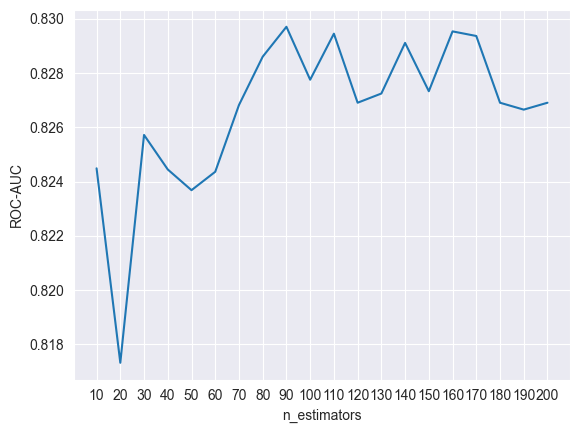

In [26]:
n_estimators_values_to_try = np.arange(10, 201, 10, dtype=int)
roc_auc_scores = []

for n_estimators in n_estimators_values_to_try:
    rand_forest = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=best_params_randforest['max_depth'],
        min_samples_split=best_params_randforest['min_samples_split'],
        random_state=52
    )
    rand_forest.fit(X_train_full, y_train_full)
    y_pred_proba_test = rand_forest.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    roc_auc_scores.append(roc_auc)
    print(f"n_estimators={n_estimators}: ROC-AUC={roc_auc}")

plt.plot(n_estimators_values_to_try, roc_auc_scores)
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.xticks(n_estimators_values_to_try)
plt.show()

На графике отчётливо видно, что auc-roc увеличивается до значения 90 (не монотонно), а после - колеблется около максимума. Считаем, что 90 - оптимальное значение для максимизации auc-roc

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?


Важность:
Glucose: 0.3121355263796271
BMI: 0.17741873761113644
Age: 0.13223959097341292
DiabetesPedigreeFunction: 0.09371693433661532
Pregnancies: 0.07852984702695442
Insulin: 0.07399119145450052
BloodPressure: 0.06853067623119795
SkinThickness: 0.06343749598655536


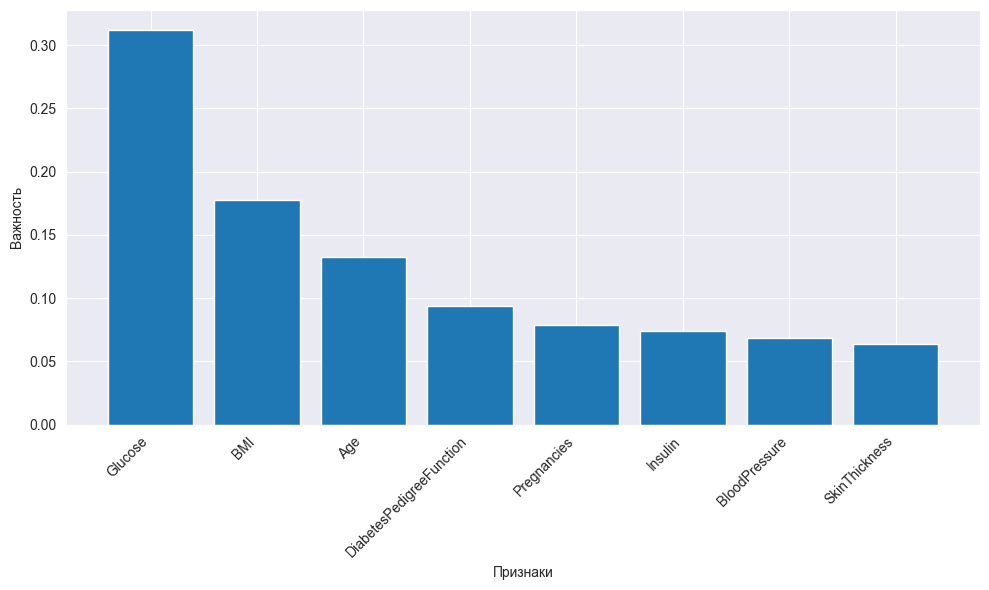

In [29]:
feature_importances = forest_best.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

print("\nВажность:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance}")

plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Для определения диабета самым важным признаком оказался `Glucose` - уровень сахара в крови, что является очевидным. Вторым по важности является `BMI` (индекс массы тела), что тоже похоже на правду, потому что обычно люди с диабетом чаще страдают от ожирения. Также возраст `Age` тоже сильно влияет на показатель наличие диабета - у пожилых людей он наблюдается чаще.